# Evaluation using QCB chemicals (medium)

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from os.path import exists

sys.path.append('../..')

In [3]:
import pylab as plt
import pandas as pd
import numpy as np
from loguru import logger
import seaborn as sns

from stable_baselines3 import DQN

In [4]:
from vimms.Common import POSITIVE, set_log_level_warning, load_obj, save_obj
from vimms.ChemicalSamplers import UniformRTAndIntensitySampler, GaussianChromatogramSampler, UniformMZFormulaSampler, \
    MZMLFormulaSampler, MZMLRTandIntensitySampler, MZMLChromatogramSampler
from vimms.Noise import UniformSpikeNoise
from vimms.Evaluation import evaluate_real
from vimms.Chemicals import ChemicalMixtureFromMZML
from vimms.Roi import RoiBuilderParams, SmartRoiParams

from mass_spec_utils.data_import.mzmine import load_picked_boxes

from vimms_gym.env import DDAEnv
from vimms_gym.chemicals import generate_chemicals
from vimms_gym.evaluation import evaluate, run_method
from vimms_gym.common import METHOD_RANDOM, METHOD_FULLSCAN, METHOD_TOPN, METHOD_DQN, METHOD_DQN_COV, METHOD_DQN_INT

In [5]:
set_log_level_warning()

1

# 1. Parameters

Parameters that will be used throughout this notebook. Should be the same as the training ones.

Chemical generation parameters

In [6]:
n_chemicals = (200, 500)
mz_range = (100, 600)
rt_range = (400, 800)
intensity_range = (1E4, 1E20)

In [7]:
n_eval_episodes = 30
env_name = 'DDAEnv'
intensity_threshold = 0.5

Evaluation parameters

In [8]:
env_name = 'DDAEnv'
intensity_threshold = 0.5
max_peaks = 200
in_dir = 'results'
out_dir = 'evaluation'
methods = [
    METHOD_RANDOM,
    METHOD_DQN_COV,
    METHOD_DQN_INT,
    METHOD_TOPN,
]

In [9]:
# topN parameters
topN_N = 10
topN_rt_tol = 15
min_ms1_intensity = 5000

# smartroi parameters
alpha = 2
beta = 0.1
smartroi_N = topN_N
smartroi_dew = topN_rt_tol

# weighteddew parameters
t0 = 10
t1 = 60
weighteddew_N = 10

Environment parameters

In [10]:
isolation_window = 0.7
rt_tol = 120
mz_tol = 10
ionisation_mode = POSITIVE

enable_spike_noise = True
noise_density = 0.1
noise_max_val = 1E3

In [11]:
params = {
    'chemical_creator': {
        'mz_range': mz_range,
        'rt_range': rt_range,
        'intensity_range': intensity_range,
        'n_chemicals': n_chemicals,
        'mz_sampler': None,
        'ri_sampler': None,
        'cr_sampler': None,
    },
    'noise': {
        'enable_spike_noise': enable_spike_noise,
        'noise_density': noise_density,
        'noise_max_val': noise_max_val,
        'mz_range': mz_range
    },
    'env': {
        'ionisation_mode': ionisation_mode,
        'rt_range': rt_range,
        'isolation_window': isolation_window,
        'mz_tol': mz_tol,
        'rt_tol': rt_tol,
    }
}

## Generate chemical sets for evaluation

In [12]:
fname = 'QCB_chems_medium.p'
found = exists(fname)
if found:
    chem_list = load_obj(fname)
    for chems in chem_list:
        print(len(chems))

274
341
436
356
428
359
383
315
351
361
465
304
420
248
407
342
367
260
425
328
415
208
265
285
243
281
390
268
498
486


Generate new chemicals if not found

In [13]:
if not found:
    repeat = 30
    logger.warning('Generating chemicals')
    min_mz = mz_range[0]
    max_mz = mz_range[1]
    min_rt = rt_range[0]
    max_rt = rt_range[1]
    min_log_intensity = np.log(intensity_range[0])
    max_log_intensity = np.log(intensity_range[1])
    
    mzml_filename = '../fullscan_QCB.mzML'
    samplers_pickle = 'samplers_QCB_medium.p'
    if exists(samplers_pickle):
        logger.info('Loaded %s' % samplers_pickle)
        samplers = load_obj(samplers_pickle)
        mz_sampler = samplers['mz']
        ri_sampler = samplers['rt_intensity']
        cr_sampler = samplers['chromatogram']
    else:
        logger.info('Creating samplers from %s' % mzml_filename)
        mz_sampler = MZMLFormulaSampler(mzml_filename, min_mz=min_mz, max_mz=max_mz)
        ri_sampler = MZMLRTandIntensitySampler(mzml_filename, min_rt=min_rt, max_rt=max_rt,
                                               min_log_intensity=min_log_intensity,
                                               max_log_intensity=max_log_intensity)
        roi_params = RoiBuilderParams(min_roi_length=3, at_least_one_point_above=5000)
        cr_sampler = MZMLChromatogramSampler(mzml_filename, roi_params=roi_params)
        samplers = {
            'mz': mz_sampler,
            'rt_intensity': ri_sampler,
            'chromatogram': cr_sampler
        }
        save_obj(samplers, samplers_pickle)
    
    chemical_creator_params = {
        'mz_range': mz_range,
        'rt_range': rt_range,
        'intensity_range': intensity_range,
        'n_chemicals': n_chemicals,
        'mz_sampler': mz_sampler,
        'ri_sampler': ri_sampler,
        'cr_sampler': cr_sampler
    }

    chem_list = []
    for i in range(repeat):
        chems = generate_chemicals(chemical_creator_params)
        print(len(chems))
        chem_list.append(chems)
        
    save_obj(chem_list, fname)

In [14]:
chem_list = chem_list[0:n_eval_episodes]
len(chem_list)

30

# 2. Evaluation

In [15]:
method_eval_results = {}
for method in methods:

    N = 0
    effective_rt_tol = rt_tol
    copy_params = dict(params)        
    copy_params['env']['rt_tol'] = effective_rt_tol
    
    custom_objects = {
        "learning_rate": 0.0,
        "lr_schedule": lambda _: 0.0,
        "clip_range": lambda _: 0.0,
    }    
    
    if method == METHOD_DQN_COV:
        model_dir = '%s_%.2f' % (in_dir, 0.75)
        fname = os.path.join(model_dir, '%s_%s.zip' % (env_name, METHOD_DQN))
        model = DQN.load(fname, custom_objects=custom_objects)
    elif method == METHOD_DQN_INT:
        model_dir = '%s_%.2f' % (in_dir, 0.25)
        fname = os.path.join(model_dir, '%s_%s.zip' % (env_name, METHOD_DQN))
        model = DQN.load(fname, custom_objects=custom_objects)        
    else:
        model = None
        if method == METHOD_TOPN:
            N = topN_N
            effective_rt_tol = topN_rt_tol
            copy_params = dict(params)        
            copy_params['env']['rt_tol'] = effective_rt_tol                        

    banner = 'method = %s max_peaks = %d N = %d rt_tol = %d' % (method, max_peaks, N, effective_rt_tol)
    print(banner)
    print()            
            
    episodic_results = run_method(env_name, copy_params, max_peaks, chem_list, method, out_dir, 
                                  N=N, min_ms1_intensity=min_ms1_intensity, model=model,
                                  print_eval=True, print_reward=False, intensity_threshold=intensity_threshold,
                                  mzml_prefix=method)
    eval_results = [er.eval_res for er in episodic_results]
    method_eval_results[method] = eval_results
    print()

method = random max_peaks = 200 N = 0 rt_tol = 120

{'coverage_prop': '0.139', 'intensity_prop': '0.069', 'ms1/ms2 ratio': '0.007', 'efficiency': '0.019', 'TP': '12', 'FP': '17', 'FN': '245', 'precision': '0.414', 'recall': '0.047', 'f1': '0.084'}
{'coverage_prop': '0.117', 'intensity_prop': '0.058', 'ms1/ms2 ratio': '0.009', 'efficiency': '0.020', 'TP': '17', 'FP': '17', 'FN': '307', 'precision': '0.500', 'recall': '0.052', 'f1': '0.095'}
{'coverage_prop': '0.117', 'intensity_prop': '0.061', 'ms1/ms2 ratio': '0.005', 'efficiency': '0.026', 'TP': '23', 'FP': '22', 'FN': '391', 'precision': '0.511', 'recall': '0.056', 'f1': '0.100'}
{'coverage_prop': '0.098', 'intensity_prop': '0.046', 'ms1/ms2 ratio': '0.008', 'efficiency': '0.018', 'TP': '10', 'FP': '20', 'FN': '326', 'precision': '0.333', 'recall': '0.030', 'f1': '0.055'}
{'coverage_prop': '0.084', 'intensity_prop': '0.039', 'ms1/ms2 ratio': '0.005', 'efficiency': '0.018', 'TP': '13', 'FP': '18', 'FN': '397', 'precision': '0.419', 'r

/opt/anaconda3/envs/vimms-gym/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:553: UserWarning:

This system does not have apparently enough memory to store the complete replay buffer 19.67GB > 0.36GB



method = DQN_COV max_peaks = 200 N = 0 rt_tol = 120

{'coverage_prop': '0.964', 'intensity_prop': '0.557', 'ms1/ms2 ratio': '2.099', 'efficiency': '0.686', 'TP': '150', 'FP': '82', 'FN': '42', 'precision': '0.647', 'recall': '0.781', 'f1': '0.708'}
{'coverage_prop': '0.962', 'intensity_prop': '0.582', 'ms1/ms2 ratio': '1.394', 'efficiency': '0.621', 'TP': '199', 'FP': '98', 'FN': '44', 'precision': '0.670', 'recall': '0.819', 'f1': '0.737'}
{'coverage_prop': '0.915', 'intensity_prop': '0.562', 'ms1/ms2 ratio': '1.081', 'efficiency': '0.630', 'TP': '239', 'FP': '126', 'FN': '71', 'precision': '0.655', 'recall': '0.771', 'f1': '0.708'}
{'coverage_prop': '0.949', 'intensity_prop': '0.597', 'ms1/ms2 ratio': '1.408', 'efficiency': '0.645', 'TP': '209', 'FP': '99', 'FN': '48', 'precision': '0.679', 'recall': '0.813', 'f1': '0.740'}
{'coverage_prop': '0.923', 'intensity_prop': '0.576', 'ms1/ms2 ratio': '1.103', 'efficiency': '0.633', 'TP': '227', 'FP': '111', 'FN': '90', 'precision': '0.672',

/opt/anaconda3/envs/vimms-gym/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:553: UserWarning:

This system does not have apparently enough memory to store the complete replay buffer 19.67GB > 0.33GB



method = DQN_INT max_peaks = 200 N = 0 rt_tol = 120

{'coverage_prop': '0.865', 'intensity_prop': '0.672', 'ms1/ms2 ratio': '0.232', 'efficiency': '0.173', 'TP': '194', 'FP': '19', 'FN': '61', 'precision': '0.911', 'recall': '0.761', 'f1': '0.829'}
{'coverage_prop': '0.842', 'intensity_prop': '0.638', 'ms1/ms2 ratio': '0.194', 'efficiency': '0.199', 'TP': '241', 'FP': '23', 'FN': '77', 'precision': '0.913', 'recall': '0.758', 'f1': '0.828'}
{'coverage_prop': '0.821', 'intensity_prop': '0.617', 'ms1/ms2 ratio': '0.176', 'efficiency': '0.242', 'TP': '301', 'FP': '34', 'FN': '101', 'precision': '0.899', 'recall': '0.749', 'f1': '0.817'}
{'coverage_prop': '0.834', 'intensity_prop': '0.618', 'ms1/ms2 ratio': '0.188', 'efficiency': '0.204', 'TP': '243', 'FP': '27', 'FN': '86', 'precision': '0.900', 'recall': '0.739', 'f1': '0.811'}
{'coverage_prop': '0.811', 'intensity_prop': '0.598', 'ms1/ms2 ratio': '0.192', 'efficiency': '0.240', 'TP': '265', 'FP': '34', 'FN': '129', 'precision': '0.886',

#### Test classic controllers in ViMMS

In [16]:
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import TopNController, TopN_SmartRoiController, WeightedDEWController
from vimms.Environment import Environment

Run Top-N Controller

In [17]:
method = 'TopN_Controller'
print('method = %s' % method)
print()

effective_rt_tol = topN_rt_tol
effective_N = topN_N
eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    controller = TopNController(ionisation_mode, effective_N, isolation_window, mz_tol, effective_rt_tol,
                                min_ms1_intensity)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    
method_eval_results[method] = eval_results

method = TopN_Controller

Episode 0 finished
{'coverage_prop': '0.967', 'intensity_prop': '0.617', 'ms1/ms2 ratio': '2.067', 'efficiency': '0.679', 'TP': '180', 'FP': '54', 'FN': '40', 'precision': '0.769', 'recall': '0.818', 'f1': '0.793'}
Episode 1 finished
{'coverage_prop': '0.941', 'intensity_prop': '0.614', 'ms1/ms2 ratio': '1.476', 'efficiency': '0.634', 'TP': '227', 'FP': '66', 'FN': '48', 'precision': '0.775', 'recall': '0.825', 'f1': '0.799'}
Episode 2 finished
{'coverage_prop': '0.933', 'intensity_prop': '0.618', 'ms1/ms2 ratio': '1.081', 'efficiency': '0.643', 'TP': '273', 'FP': '99', 'FN': '64', 'precision': '0.734', 'recall': '0.810', 'f1': '0.770'}
Episode 3 finished
{'coverage_prop': '0.952', 'intensity_prop': '0.616', 'ms1/ms2 ratio': '1.438', 'efficiency': '0.657', 'TP': '223', 'FP': '82', 'FN': '51', 'precision': '0.731', 'recall': '0.814', 'f1': '0.770'}
Episode 4 finished
{'coverage_prop': '0.930', 'intensity_prop': '0.609', 'ms1/ms2 ratio': '1.002', 'efficiency': '

Run SmartROI Controller

In [18]:
method = 'SmartROI_Controller'
print('method = %s' % method)
print()

eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    
    roi_params = RoiBuilderParams(min_roi_intensity=0, min_roi_length=0)    
    smartroi_params = SmartRoiParams(intensity_increase_factor=alpha, drop_perc=beta/100.0)
    controller = TopN_SmartRoiController(ionisation_mode, isolation_window, smartroi_N, mz_tol, smartroi_dew,
                                min_ms1_intensity, roi_params, smartroi_params)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    
method_eval_results[method] = eval_results

method = SmartROI_Controller

Episode 0 finished
{'coverage_prop': '0.496', 'intensity_prop': '0.332', 'ms1/ms2 ratio': '4.794', 'efficiency': '0.720', 'TP': '88', 'FP': '27', 'FN': '159', 'precision': '0.765', 'recall': '0.356', 'f1': '0.486'}
Episode 1 finished
{'coverage_prop': '0.510', 'intensity_prop': '0.328', 'ms1/ms2 ratio': '3.424', 'efficiency': '0.682', 'TP': '119', 'FP': '36', 'FN': '186', 'precision': '0.768', 'recall': '0.390', 'f1': '0.517'}
Episode 2 finished
{'coverage_prop': '0.479', 'intensity_prop': '0.295', 'ms1/ms2 ratio': '2.882', 'efficiency': '0.706', 'TP': '134', 'FP': '56', 'FN': '246', 'precision': '0.705', 'recall': '0.353', 'f1': '0.470'}
Episode 3 finished
{'coverage_prop': '0.463', 'intensity_prop': '0.300', 'ms1/ms2 ratio': '3.722', 'efficiency': '0.696', 'TP': '111', 'FP': '35', 'FN': '210', 'precision': '0.760', 'recall': '0.346', 'f1': '0.475'}
Episode 4 finished
{'coverage_prop': '0.495', 'intensity_prop': '0.311', 'ms1/ms2 ratio': '2.628', 'efficie

Run WeightedDEW Controller

In [19]:
method = 'WeightedDEW_Controller'
print('method = %s' % method)
print()

eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    
    controller = WeightedDEWController(ionisation_mode, weighteddew_N, isolation_window, mz_tol, t1,
                                min_ms1_intensity, exclusion_t_0=t0)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    
method_eval_results[method] = eval_results

method = WeightedDEW_Controller

Episode 0 finished
{'coverage_prop': '0.949', 'intensity_prop': '0.628', 'ms1/ms2 ratio': '1.612', 'efficiency': '0.549', 'TP': '182', 'FP': '50', 'FN': '42', 'precision': '0.784', 'recall': '0.812', 'f1': '0.798'}
Episode 1 finished
{'coverage_prop': '0.947', 'intensity_prop': '0.647', 'ms1/ms2 ratio': '1.082', 'efficiency': '0.511', 'TP': '234', 'FP': '59', 'FN': '48', 'precision': '0.799', 'recall': '0.830', 'f1': '0.814'}
Episode 2 finished
{'coverage_prop': '0.917', 'intensity_prop': '0.621', 'ms1/ms2 ratio': '0.802', 'efficiency': '0.521', 'TP': '283', 'FP': '87', 'FN': '66', 'precision': '0.765', 'recall': '0.811', 'f1': '0.787'}
Episode 3 finished
{'coverage_prop': '0.941', 'intensity_prop': '0.633', 'ms1/ms2 ratio': '1.081', 'efficiency': '0.529', 'TP': '238', 'FP': '67', 'FN': '51', 'precision': '0.780', 'recall': '0.824', 'f1': '0.801'}
Episode 4 finished
{'coverage_prop': '0.902', 'intensity_prop': '0.609', 'ms1/ms2 ratio': '0.749', 'efficie

#### Plotting

Flatten data into dataframe

In [20]:
data = []
for method in method_eval_results:
    eval_results = method_eval_results[method]
    for eval_res in eval_results:
        row = (
            method, 
            float(eval_res['coverage_prop']), 
            float(eval_res['intensity_prop']), 
            float(eval_res['ms1/ms2 ratio']), 
            float(eval_res['efficiency']),
            float(eval_res['precision']),
            float(eval_res['recall']),
            float(eval_res['f1']),            
        )
        data.append(row)
        
df = pd.DataFrame(data, columns=['method', 'coverage_prop', 'intensity_prop', 'ms1/ms2_ratio', 'efficiency', 'precision', 'recall', 'f1'])
# df.set_index('method', inplace=True)
df.head()

,method,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
0,random,0.139,0.069,0.007,0.019,0.414,0.047,0.084
1,random,0.117,0.058,0.009,0.020,0.500,0.052,0.095
2,random,0.117,0.061,0.005,0.026,0.511,0.056,0.100
3,random,0.098,0.046,0.008,0.018,0.333,0.030,0.055
4,random,0.084,0.039,0.005,0.018,0.419,0.032,0.059


In [21]:
sns.set_context("poster")

Text(0.5, 1.0, 'Coverage Proportion')

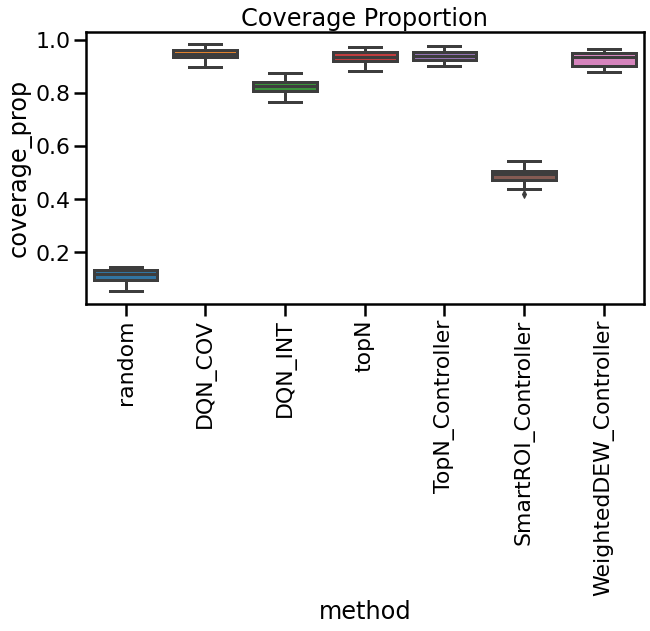

In [22]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='coverage_prop')
plt.xticks(rotation=90)
plt.title('Coverage Proportion')

Text(0.5, 1.0, 'Intensity Proportion')

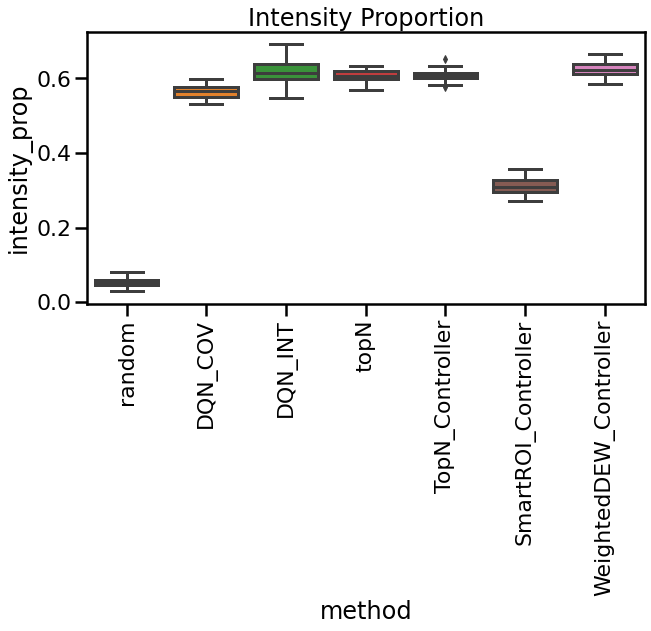

In [23]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='intensity_prop')
plt.xticks(rotation=90)
plt.title('Intensity Proportion')

Text(0.5, 1.0, 'MS1/MS2 Ratio')

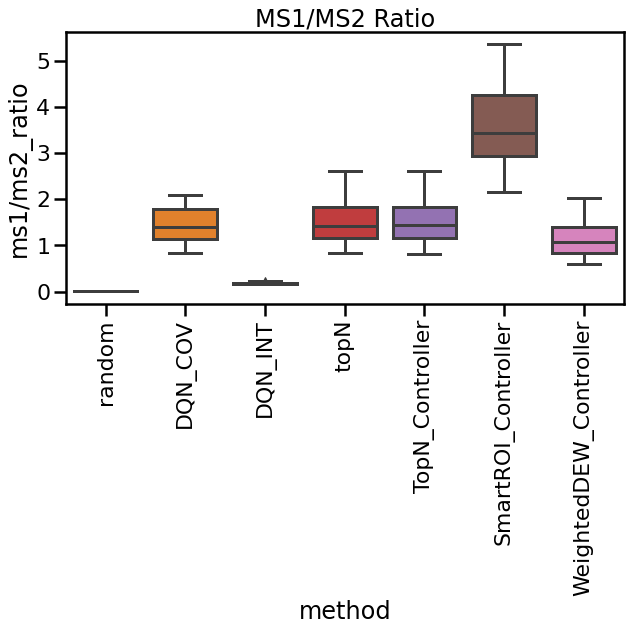

In [24]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='ms1/ms2_ratio')
plt.xticks(rotation=90)
plt.title('MS1/MS2 Ratio')

Text(0.5, 1.0, 'Efficiency')

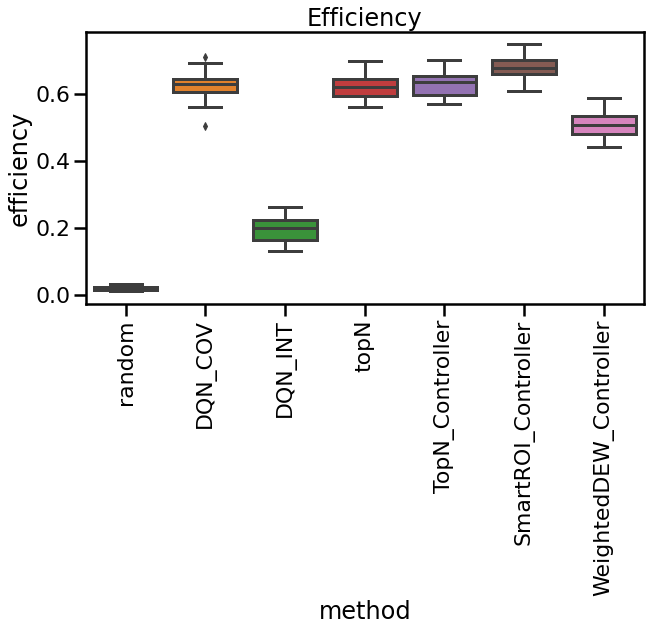

In [25]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='efficiency')
plt.xticks(rotation=90)
plt.title('Efficiency')

Text(0.5, 1.0, 'Precision')

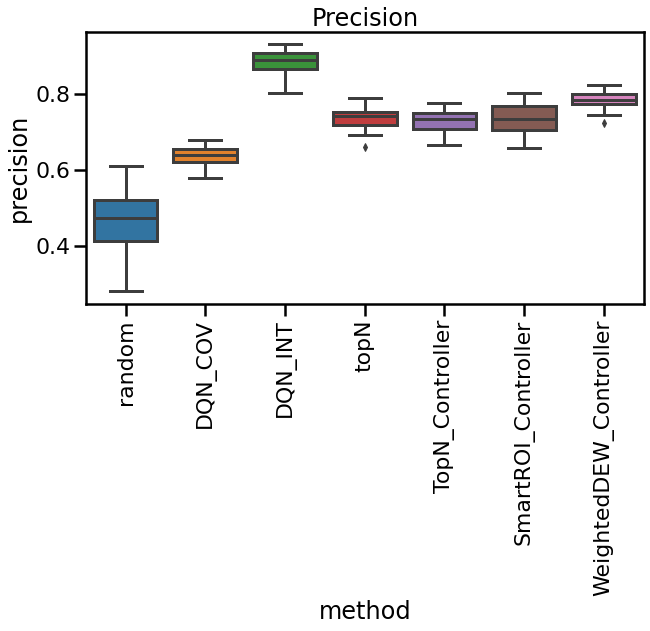

In [26]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='precision')
plt.xticks(rotation=90)
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

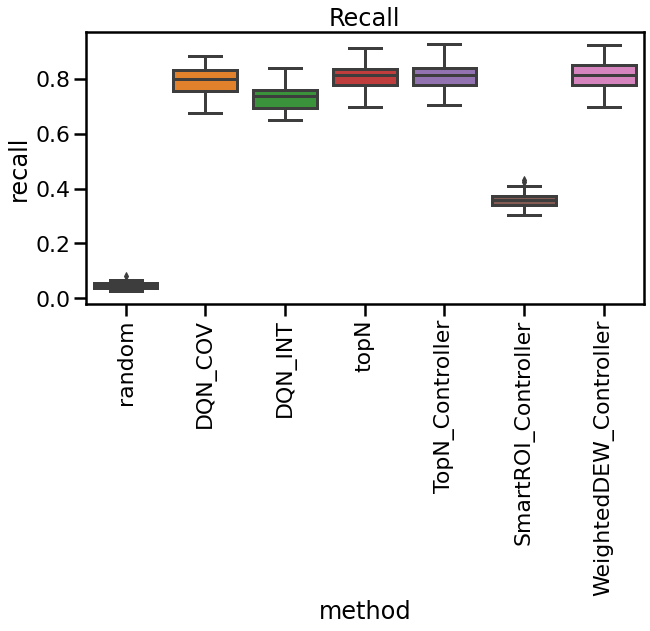

In [27]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='recall')
plt.xticks(rotation=90)
plt.title('Recall')

Text(0.5, 1.0, 'F1')

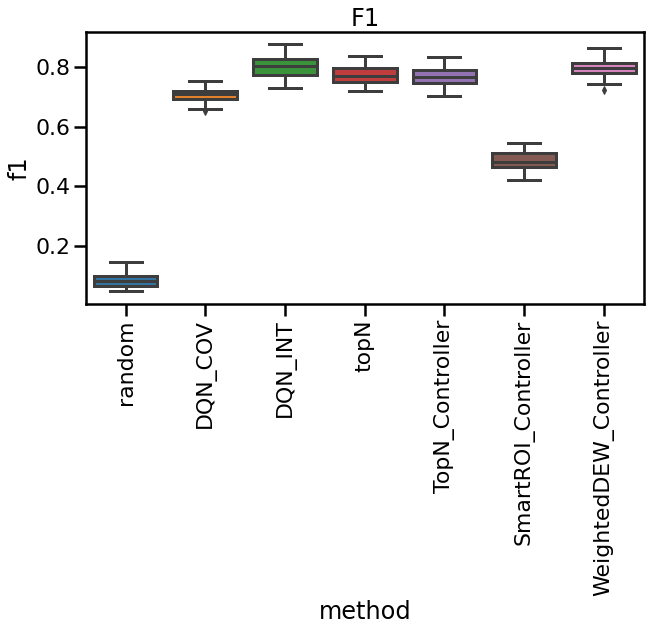

In [28]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='f1')
plt.xticks(rotation=90)
plt.title('F1')

In [29]:
df.to_pickle('evaluation.p')

### Without 'random'

In [30]:
df = pd.read_pickle('evaluation.p')

In [31]:
new_df = df[df.method != 'random']
new_df.head()

,method,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
30,DQN_COV,0.964,0.557,2.099,0.686,0.647,0.781,0.708
31,DQN_COV,0.962,0.582,1.394,0.621,0.670,0.819,0.737
32,DQN_COV,0.915,0.562,1.081,0.630,0.655,0.771,0.708
33,DQN_COV,0.949,0.597,1.408,0.645,0.679,0.813,0.740
34,DQN_COV,0.923,0.576,1.103,0.633,0.672,0.716,0.693


In [32]:
new_df = new_df[new_df.method != 'SmartROI_Controller']
new_df.head()

,method,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
30,DQN_COV,0.964,0.557,2.099,0.686,0.647,0.781,0.708
31,DQN_COV,0.962,0.582,1.394,0.621,0.670,0.819,0.737
32,DQN_COV,0.915,0.562,1.081,0.630,0.655,0.771,0.708
33,DQN_COV,0.949,0.597,1.408,0.645,0.679,0.813,0.740
34,DQN_COV,0.923,0.576,1.103,0.633,0.672,0.716,0.693


Text(0.5, 1.0, 'Coverage Proportion')

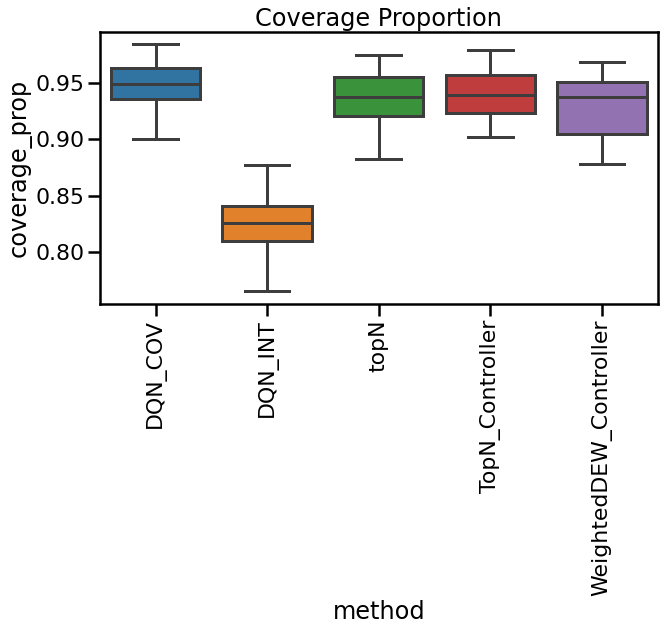

In [33]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='coverage_prop', showfliers = False)
plt.xticks(rotation=90)
plt.title('Coverage Proportion')

Text(0.5, 1.0, 'Intensity Proportion')

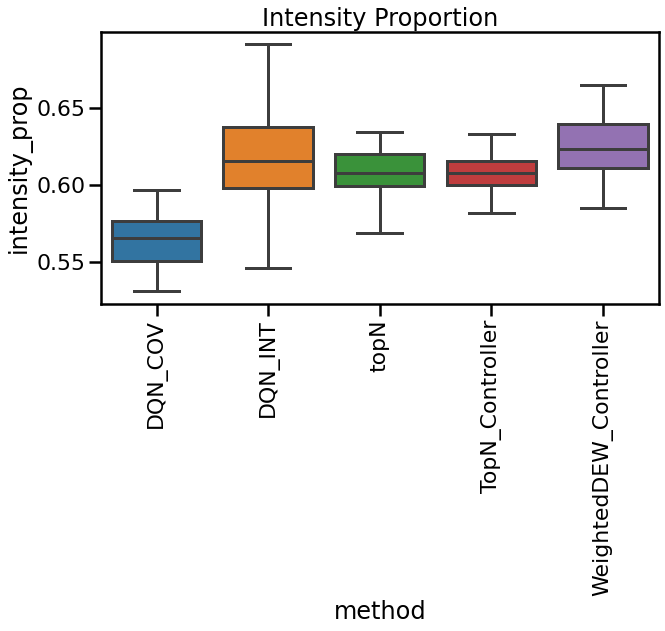

In [34]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='intensity_prop', showfliers = False)
plt.xticks(rotation=90)
plt.title('Intensity Proportion')

Text(0.5, 1.0, 'MS1/MS2 Ratio')

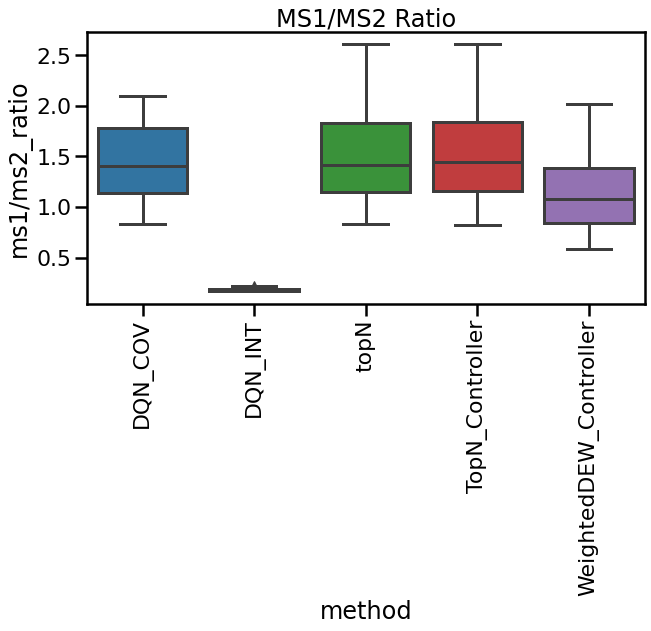

In [35]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='ms1/ms2_ratio')
plt.xticks(rotation=90)
plt.title('MS1/MS2 Ratio')

Text(0.5, 1.0, 'Precision')

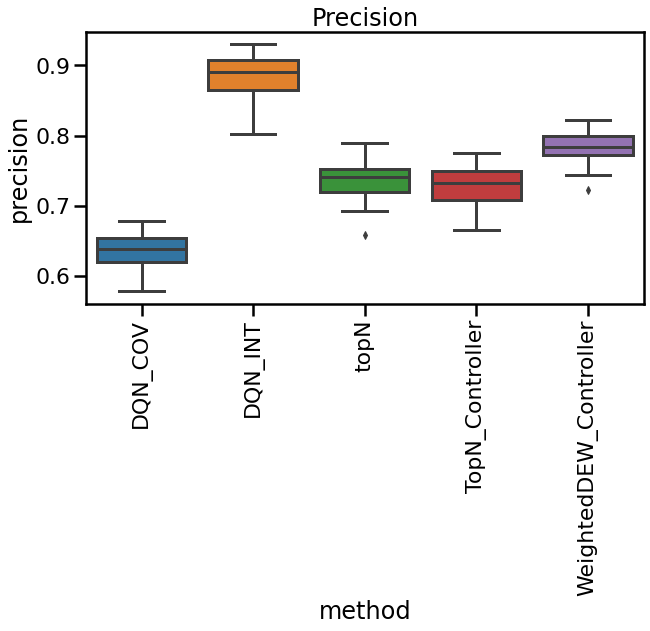

In [36]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='precision')
plt.xticks(rotation=90)
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

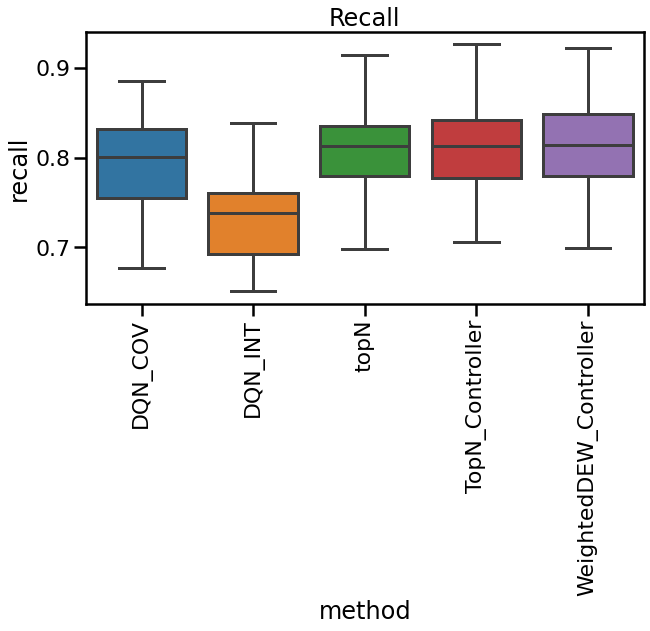

In [37]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='recall')
plt.xticks(rotation=90)
plt.title('Recall')

Text(0.5, 1.0, 'F1')

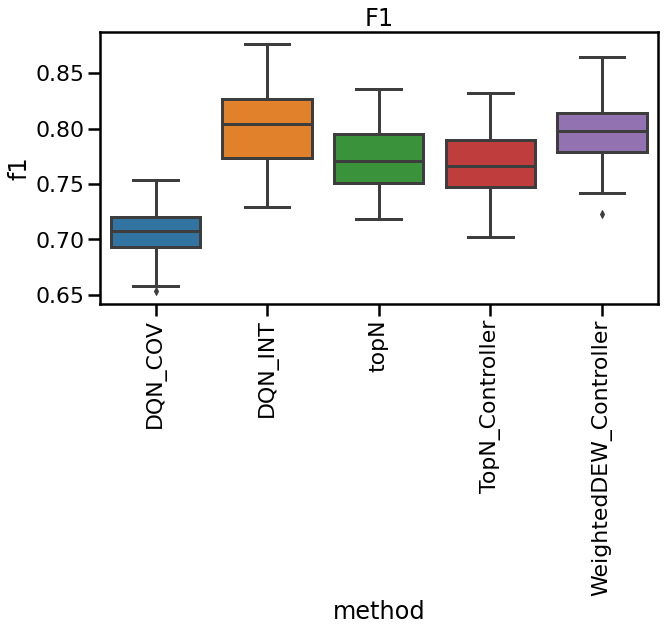

In [38]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='f1')
plt.xticks(rotation=90)
plt.title('F1')